<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse throigh the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install osmnx==0.13.0 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 22 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-underscore all 1.8.3~dfsg-1 [59.9 kB]
Get:4 htt

In [23]:
import fiona
import os,os.path
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from numpy import arange

# optimization-related
import time

In [3]:
place_name = "Hyde Park, Chicago, Illinois, USA"

graph = ox.graph_from_place(place_name, network_type='walk')

In [8]:
graph

In [4]:
ox.save_graph_shapefile(graph, filepath='./source')

In [5]:
!ls source

edges.cpg  edges.prj  edges.shx  nodes.dbf  nodes.shp
edges.dbf  edges.shp  nodes.cpg  nodes.prj  nodes.shx


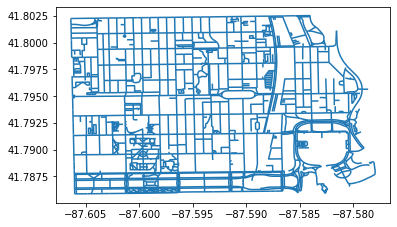

In [6]:
osm_map = gpd.read_file('source/edges.shp')
osm_map.plot()

In [10]:
osm_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         2057 non-null   int64   
 1   v         2057 non-null   int64   
 2   key       2057 non-null   int64   
 3   osmid     2057 non-null   object  
 4   highway   2057 non-null   object  
 5   oneway    2057 non-null   int64   
 6   length    2057 non-null   float64 
 7   from      2057 non-null   int64   
 8   to        2057 non-null   int64   
 9   tunnel    44 non-null     object  
 10  access    30 non-null     object  
 11  name      822 non-null    object  
 12  lanes     134 non-null    object  
 13  service   296 non-null    object  
 14  ref       5 non-null      object  
 15  maxspeed  15 non-null     object  
 16  bridge    5 non-null      object  
 17  width     1 non-null      object  
 18  geometry  2057 non-null   geometry
dtypes: float64(1), geometry(1), int64(6), ob

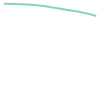

In [58]:
#osm_map_flt['osmid']
osm_map_flt['geometry'].iloc[0]

In [85]:
project = partial(pyproj.transform, pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
project2 = partial(pyproj.transform, pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))

len_4326 = []
len_3857 = []
num_coords = []

for index, row in osm_map_flt.iterrows():
  line = row['geometry']
  num_coords.append(len(line.coords))
  len_4326.append(line.length)
  line2 = transform(project, line)
  len_3857.append(line2.length) # in meters


In [87]:
quick_df = pd.DataFrame({'num_coords': num_coords, 'len_4326':len_4326, 'len_3857':len_3857})
quick_df['ratio'] = quick_df['len_4326'] / quick_df['len_3857']

In [91]:
quick_df.head(20)

,num_coords,len_4326,len_3857,ratio
0,8,0.001253,3268.734388,3.834600e-07
1,4,0.000386,822.672251,4.695470e-07
2,4,0.000541,531.171571,1.017884e-06
3,8,0.001907,4818.967331,3.957057e-07
4,4,0.000689,1811.230928,3.803259e-07
5,2,0.000373,983.933351,3.786367e-07
6,2,0.000536,1416.866187,3.785514e-07
7,2,0.000503,1333.292771,3.773616e-07
8,3,0.000781,2068.689388,3.774602e-07
9,6,0.000604,518.581695,1.165032e-06


In [88]:
quick_df.describe()

,num_coords,len_4326,len_3857,ratio
count,632.000000,632.000000,632.000000,6.320000e+02
mean,3.077532,0.000642,920.323572,3.131035e-06
std,2.587671,0.000515,1142.718814,3.475484e-06
min,2.000000,0.000017,2.902307,3.752201e-07
25%,2.000000,0.000215,92.307655,3.776656e-07
50%,2.000000,0.000547,345.892601,5.629150e-07
75%,3.000000,0.000838,1482.816181,7.646045e-06
max,32.000000,0.003588,6841.402583,8.929006e-06


In [71]:
def sample_points(shapefile, sample_dist, visualize=True):

  # load the shape file: should be edges
  osm_map = gpd.read_file(shapefile)

  # filter the load
  flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ',
              'pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk',
              'secondary','secondary_link','tertiary_link','bridleway','service']

  # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
  flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)
  print('Filtering done: all rows', len(flt_idx), ', after: ', sum(flt_idx))

  # get bearing for each road
  #osm_map_flt = osm_map[flt_idx]
  #osm_map_flt['bearing'] = osm_map_flt['geometry'].apply(lambda line: round(ox.bearing.get_bearing(line.coords[0], line.coords[1])))

  # get the minimum distance in EPSG:4326
  project = partial(pyproj.transform, pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
  project2 = partial(pyproj.transform, pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))
  line = osm_map_flt['geometry'].iloc[20]
  length_4326 = line.length
  line2 = transform(project, line)
  length_3857 = line2.length # in meters
  sample_dist_4326 = sample_dist * length_4326 / length_3857
  print('Line 1 length_4326: ', length_4326, ', len_3857: ', length_3857, ', smp_dist: ', sample_dist, ', smp_dist_4326: ', sample_dist_4326)
  print('Sampling ', round(line.length/sample_dist_4326), ' points from the first line.')

  # sampling the points
  count = 0
  results = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    results.extend([
      line.interpolate(dist) #[line.interpolate(dist), row['osmid']]
      for dist in arange(sample_dist_4326/2, line.length, sample_dist_4326)
    ])

    count += 1
    if (count % 100 == 0):
      print('Processed: ', count, ', points: ', len(results))

  return results


In [72]:
xxx = sample_points('source/edges.shp', 50)

Filtering done: all rows 2057 , after:  632
Line 1 length_4326:  0.0008141203842238759 , len_3857:  2160.2960282231093 , smp_dist:  50 , smp_dist_4326:  1.8842796857185997e-05
Sampling  43  points from the first line.
Processed:  100 , points:  3573
Processed:  200 , points:  7125
Processed:  300 , points:  10186
Processed:  400 , points:  13445
Processed:  500 , points:  16337
Processed:  600 , points:  19776


In [49]:
picked_gdf = gpd.GeoSeries(xxx)
picked_gdf.head()

0    POINT (-87.58204 41.79280)
1    POINT (-87.58202 41.79280)
2    POINT (-87.58200 41.79280)
3    POINT (-87.58198 41.79280)
4    POINT (-87.58196 41.79280)
dtype: geometry

KeyError: ignored

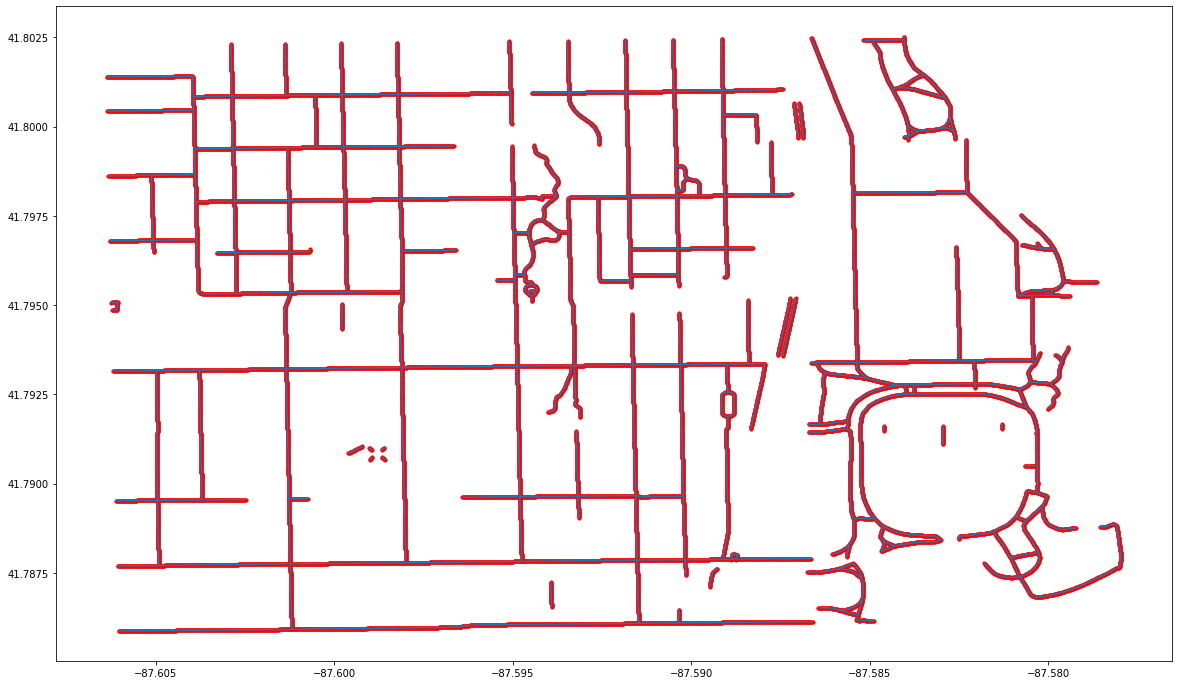

In [73]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map_flt.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)
osm_map_flt.loc[[20], 'geometry'].plot(ax=ax, color='yellow', linewidth=10)

In [11]:
flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ','pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk','secondary','secondary_link','tertiary_link','bridleway','service']

# clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)

print('all rows', len(flt_idx), ', after filtering: ', sum(flt_idx))

all rows 2057 , after filtering:  632


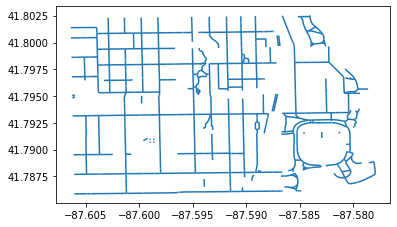

In [13]:
osm_map_flt = osm_map[flt_idx]
osm_map_flt.plot()

In [20]:
print(osm_map_flt['geometry'].iloc[0].coords[0])
print(osm_map_flt['geometry'].iloc[0].coords[1])
print(ox.bearing.get_bearing(osm_map_flt['geometry'].iloc[0].coords[0], osm_map_flt['geometry'].iloc[0].coords[1]))
osm_map_flt['geometry'].apply(lambda line: round(ox.bearing.get_bearing(line.coords[0], line.coords[1])))

(-87.5820499, 41.7927999)
(-87.5819167, 41.7927962)
359.93285098792103


0       360
1       183
2       174
4       359
5         0
       ... 
2042    116
2043    120
2044    120
2045    113
2055    180
Name: geometry, Length: 632, dtype: int64

In [ ]:
#osm_map_flt.info()
line = osm_map_flt['geometry'].iloc[0]
length_4326 = line.length
print(length_4326)

0.0009060128586278044


In [ ]:
project = partial(pyproj.transform, pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
project2 = partial(pyproj.transform, pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))

line2 = transform(project, line)
length_3857 = line2.length # in meters
print(length_3857)

107.7069664783583


In [ ]:
# mini_dist in EPSG:4326
unit_dist = 50 # meters
unit_dist_4326 = unit_dist * length_4326 / length_3857

In [ ]:
from numpy import arange

def sample_points(line, mini_dist):
  return [line.interpolate(distance) for distance in arange(0, line.length, mini_dist)]

sample_points_numba = jit()(sample_points)

print(sample_points(osm_map_flt['geometry'].iloc[0], unit_dist_4326))


[<shapely.geometry.point.Point object at 0x7efe44389f60>, <shapely.geometry.point.Point object at 0x7efe443890f0>, <shapely.geometry.point.Point object at 0x7efe44389908>, <shapely.geometry.point.Point object at 0x7efe43f12160>, <shapely.geometry.point.Point object at 0x7efe43f12ef0>, <shapely.geometry.point.Point object at 0x7efe43f12198>]


In [ ]:
%timeit sample_points(osm_map_flt['geometry'].iloc[0], unit_dist_4326)

The slowest run took 10.34 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 111 µs per loop


In [ ]:
#%timeit sample_points_numba(osm_map_flt['geometry'].iloc[0], unit_dist_4326)

In [ ]:
count = 0
picked_points = []

#project = partial(pyproj.transform, pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
#project2 = partial(pyproj.transform, pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))

for line in osm_map_flt['geometry']:
  picked_points.extend(sample_points(line, unit_dist_4326))
  
  count += 1
  if (count % 100 == 0):
    print('Processed: ', count, ', points: ', len(picked_points))



Processed:  100 , points:  244
Processed:  200 , points:  479
Processed:  300 , points:  693
Processed:  400 , points:  887
Processed:  500 , points:  1070
Processed:  600 , points:  1233


In [ ]:
picked_gdf = gpd.GeoSeries(picked_points)
picked_gdf.head()

0    POINT (-87.58839 41.79335)
1    POINT (-87.58840 41.79377)
2    POINT (-87.58840 41.79419)
3    POINT (-87.58841 41.79457)
4    POINT (-87.59164 41.79332)
dtype: geometry

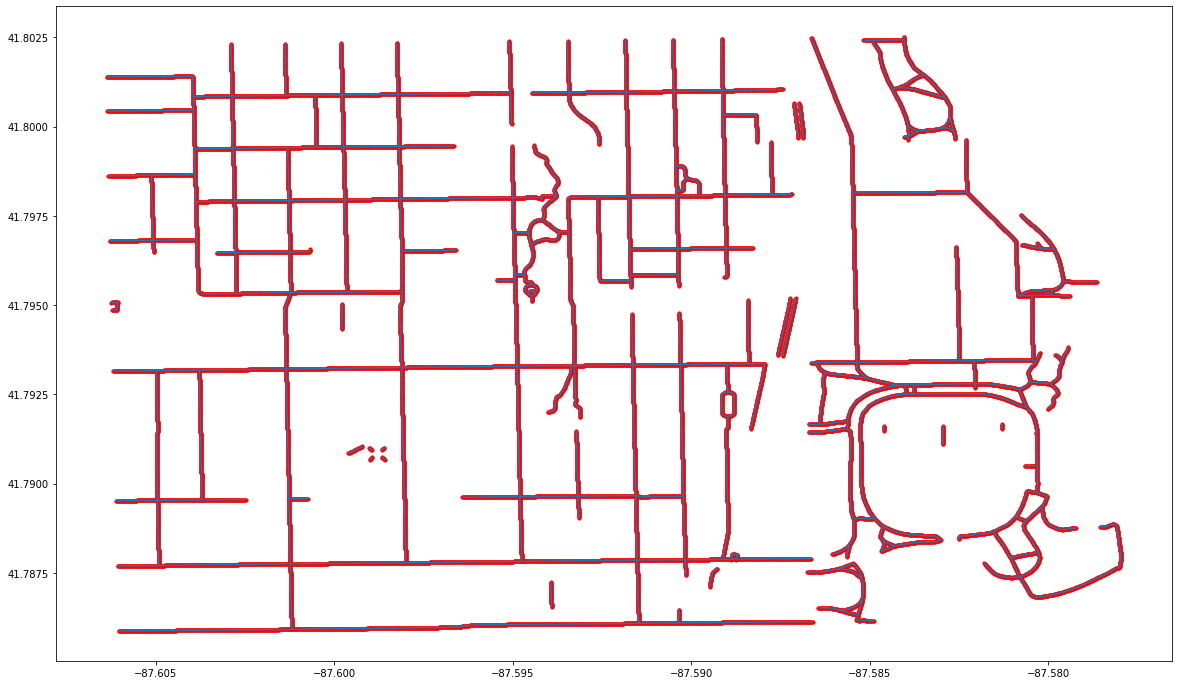

In [50]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map_flt.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)

In [ ]:
# sampled points schema

mini_dist = 20 # meters

schema = {
  'geometry': 'Point',
  'properties': {'id': 'int'},
}

In [ ]:
outshp = os.path.join(root,'sampled_20m.shp')

count = 0
  
# Create pointS along the streets
with fiona.drivers():
  #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
  with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
    for line in fiona.open(temp_cleanedStreetmap):
      first = shape(line['geometry'])
      
      length = first.length
      
      try:
        # convert degree to meter, in order to split by distance in meter
        #project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        project = partial(pyproj.transform,pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        
        line2 = transform(project, first)
        linestr = list(line2.coords)
        dist = mini_dist #set
        for distance in range(0,int(line2.length), dist):
          point = line2.interpolate(distance)
          
          # convert the local projection back the the WGS84 and write to the output shp
          project2 = partial(pyproj.transform,pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))
          point = transform(project2, point)
          output.write({'geometry':mapping(point),'properties': {'id':1}})

      except:
        print ("You should make sure the input shapefile is WGS84")
      
      count += 1
      if (count % 100 == 0):
        print('processed ', count, ' lines ...')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FionaDeprecationWarning: Use fiona.Env() instead.
  


You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
